In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf

In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-0df2e36c-a100-6777-1b08-28d87f525886)


In [5]:
!nvidia-smi

Tue Jan 18 08:18:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Get the Helper Functions

In [6]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-18 08:18:10--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-18 08:18:10 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [7]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

# Download Dataset

In [8]:
# download the dataset from kaggle
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2022-01-18 08:18:10--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 172.217.218.128, 142.250.153.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2022-01-18 08:18:10 (154 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [9]:
# Unzip Data
unzip_data("nlp_getting_started.zip")

# PreProcessing

In [10]:
# Turn CSV files into dataframe
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [11]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
train_df["text"][1]

'Forest fire near La Ronge Sask. Canada'

In [13]:
# Shuffling the Training DataFrame
train_df_shuffled = train_df.sample(frac=1,
                                  random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [14]:
# What does test dataframe look like
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [15]:
# how many classes are there in the target 
print(train_df.target.value_counts())
print('\n')
print(train_df.target.value_counts(normalize=True))

0    4342
1    3271
Name: target, dtype: int64


0    0.57034
1    0.42966
Name: target, dtype: float64


In [16]:
# how many total samples
print(len(train_df))
print(len(test_df))

7613
3263


In [17]:
# Let's visualize some random training examples
import random

random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target>0 else "(not real disaster)")
    print(f"Text:\n{text}\n")
    print("---\n")

Target: 0 (not real disaster)
Text:
@Silent0siris why not even more awesome norse landscapes with loads of atmosphere and life than boring/dead snotgreen wastelands =/

---

Target: 0 (not real disaster)
Text:
San Jose: Demolition of Willow Glen Trestle put off while legal battles continue http://t.co/t4AXZ7Kc3S

---

Target: 0 (not real disaster)
Text:
#BreakingNews http://t.co/gAN14PW9TG FedEx no longer willing to transport research specimens of potential bioterÛ_ http://t.co/5n4hUsewLy

---

Target: 1 (real disaster)
Text:
CNN News August 5 2015 Two trains derailed amid floods ...
Video for india august flooding 2015 video youtube?... http://t.co/MMIyE1k8ZZ

---

Target: 0 (not real disaster)
Text:
Panic at the disco te amo

---



# Split The Dataset

In [18]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                           train_df_shuffled["target"].to_numpy(),
                                                                           test_size=0.1, # use 10% training dataset for validation,
                                                                           random_state=42)
                                                            

In [19]:
# Check the lenghts 
print(len(train_sentences))
print(len(train_labels))
print(len(val_sentences))
print(len(val_labels))

6851
6851
762
762


In [20]:
# check the first 10 exaples
print(train_sentences[:10])
print('\n')
print(train_labels[:10])

['@mogacola @zamtriossu i screamed after hitting tweet'
 'Imagine getting flattened by Kurt Zouma'
 '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....'
 "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet"
 'Somehow find you and I collide http://t.co/Ee8RpOahPk'
 '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao'
 'destroy the free fandom honestly'
 'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE'
 '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.'
 'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt']


[0 0 1 0 0 1 1 0 1 1]


In [21]:
def calculate_results(y_true, y_pred):
    """calculates the model accuracy, precision, recall and f1 score of a binary classification model
    Args:
    -----
    y_true = true labels in the form of a 1D array
    y_pred = predicted labels in the form of 1D array
    
    Returns a dictionary of accuracy, precision, recall and f1 score
    """
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support
    
    # calculate the model accuracy
    model_accuracy = accuracy_score(y_true, y_pred)*100
    
    # calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                   y_pred,
                                                                                  average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
    
    return model_results

In [22]:
# Create a function to Compare 2 model performances


# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
    for key, value in baseline_results.items():
        print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

# Model 0: Baseline Model

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [96]:
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [97]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [98]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

# Model 6 : Tranfer Learning for using Universal Sentence Encoder

For all of the previous deep learning models we've built and trained, we've created and used our own embeddings from scratch each time.

However, a common practice is to leverage pretrained embeddings through transfer learning. This is one of the main benefits of using deep models: being able to take what one (often larger) model has learned (often on a large amount of data) and adjust it for our own use case.

For our next model, instead of using our own embedding layer, we're going to replace it with a pretrained embedding layer.

More specifically, we're going to be using the Universal Sentence Encoder from TensorFlow Hub (a great resource containing a plethora of pretrained model resources for a variety of tasks).

🔑 Note: There are many different pretrained text embedding options on TensorFlow Hub, however, some require different levels of text preprocessing than others. Best to experiment with a few and see which best suits your use case.
The main difference between the embedding layer we created and the Universal Sentence Encoder is that rather than create a word-level embedding, the Universal Sentence Encoder, as you might've guessed, creates a whole sentence-level embedding.

Our embedding layer also outputs an a 128 dimensional vector for each word, where as, the Universal Sentence Encoder outputs a 512 dimensional vector for each sentence.

We can load in a TensorFlow Hub module using the hub.load() method and passing it the target URL of the module we'd like to use, in our case, it's "https://tfhub.dev/google/universal-sentence-encoder/4".

Let's load the Universal Sentence Encoder model and test it on a couple of sentences.

In [23]:
# create a tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

# create directory to save Tensorboard logs
SAVE_DIR = "model_log"

In [24]:
sample_sentence = "There's a flood in my street!"

In [25]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

embed_samples = embed([sample_sentence,
                      "when you call the Universal Senetence Encoder on a sentence, it turns into numbers"])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [26]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

Passing our sentences to the Universal Sentence Encoder (USE) encodes them from strings to 512 dimensional vectors, which make no sense to us but hopefully make sense to our machine learning models.

Speaking of models, let's build one with the USE as our embedding layer.

We can convert the TensorFlow Hub USE module into a Keras layer using the hub.KerasLayer class.

**Note:** Due to the size of the USE TensorFlow Hub module, it may take a little while to download. Once it's downloaded though, it'll be cached and ready to use. And as with many TensorFlow Hub modules, there is a "lite" version of the USE which takes up less space but sacrifices some performance and requires more preprocessing steps. However, depending on your available compute power, the lite version may be better for your application use case.

In [27]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 

In [28]:
# create model using Sequential API
from tensorflow.keras import layers 

model_6 = tf.keras.Sequential([
                               sentence_encoder_layer, # take in sentences and then encode them into an embedding
                               layers.Dense(64, activation = "relu"),
                               layers.Dense(1, activation ="sigmoid")],
                              name = "model_6_USE")

# compile the model
model_6.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [29]:
# get the model summary
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________




Notice the number of paramters in the USE layer, these are the pretrained weights its learned on various text sources (Wikipedia, web news, web question-answer forums, etc, see the Universal Sentence Encoder paper for more).

The trainable parameters are only in our output layers, in other words, we're keeping the USE weights frozen and using it as a feature-extractor. We could fine-tune these weights by setting trainable=True when creating the hub.KerasLayer instance.

Now we've got a feature extractor model ready, let's train it and track its results to TensorBoard using our create_tensorboard_callback() function.


In [30]:
# Train a classifier on top of pre trained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "model_6_tfhub_universal_sentence_encoder")])

Saving TensorBoard log files to: model_log/model_6_tfhub_universal_sentence_encoder/20220118-081838
Epoch 1/5
215/215 [==============================] - 5s 13ms/step - loss: 0.5012 - accuracy: 0.7857 - val_loss: 0.4496 - val_accuracy: 0.8058
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4150 - accuracy: 0.8156 - val_loss: 0.4381 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.4005 - accuracy: 0.8231 - val_loss: 0.4370 - val_accuracy: 0.8045
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3932 - accuracy: 0.8253 - val_loss: 0.4331 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3864 - accuracy: 0.8283 - val_loss: 0.4231 - val_accuracy: 0.8150


In [31]:
# Make Predictions with USE TFHUB model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

array([[0.18763335],
       [0.7952674 ],
       [0.9892095 ],
       [0.20039962],
       [0.7544839 ],
       [0.7141972 ],
       [0.98272115],
       [0.983064  ],
       [0.95366347],
       [0.12327275]], dtype=float32)

In [32]:
# Convert the probabilities to classes
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [33]:
# Calculate the Performance Metrics of the models
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.49606299212599,
 'f1': 0.8143707124948604,
 'precision': 0.8150356086855799,
 'recall': 0.8149606299212598}

In [34]:
baseline_results = {'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

In [35]:
# Compare the TF Hub Modle to the Baseline Model
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 79.27, New accuracy: 81.50, Difference: 2.23
Baseline f1: 0.79, New f1: 0.81, Difference: 0.03
Baseline precision: 0.81, New precision: 0.82, Difference: 0.00
Baseline recall: 0.79, New recall: 0.81, Difference: 0.02


# Model 7 : Tensorflow Hub PreTrained Sentence Encoder on 10% of the training Data

One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data (the USE paper even mentions this in the abstract).

To put this to the test, we're going to make a small subset of the training data (10%), train a model and evaluate it.

In [36]:
# Create subset of 10% the training data
train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
train_10_percent.head(), len(train_10_percent)

(                                                   text  target
 4955  DFR EP016 Monthly Meltdown - On Dnbheaven 2015...       0
 584   FedEx no longer to transport bioterror germs i...       0
 7411  Gunmen kill four in El Salvador bus attack: Su...       1
 5950  @camilacabello97 Internally and externally scr...       1
 5541  Radiation emergency #preparedness starts with ...       1, 761)

In [37]:
train_sentences_10_percent = train_10_percent["text"].to_list()
train_labels_10_percent = train_10_percent["target"].to_list()

len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [38]:
# check the number of target in our data subset
train_10_percent["target"].value_counts()

0    413
1    348
Name: target, dtype: int64



To make sure we're making an appropriate comparison between our model's ability to learn from the full training set and 10% subset, we'll clone our USE model (model_6) using the tf.keras.models.clone_model() method.

Doing this will create the same architecture but reset the learned weights of the clone target (pretrained weights from the USE will remain but all others will be reset).


In [39]:
# Clone Model_6 but reset the model weights
model_7 = tf.keras.models.clone_model(model_6)

# compile the model
model_7.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Get a model summary
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [40]:
# Fit the model on 10% of the training data
model_7_history = model_7.fit(x = train_sentences_10_percent,
                              y = train_labels_10_percent,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "model_7_10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_log/model_7_10_percent_tf_hub_sentence_encoder/20220118-081857
Epoch 1/5
24/24 [==============================] - 3s 39ms/step - loss: 0.6676 - accuracy: 0.6978 - val_loss: 0.6256 - val_accuracy: 0.8018
Epoch 2/5
24/24 [==============================] - 1s 24ms/step - loss: 0.5915 - accuracy: 0.7976 - val_loss: 0.5431 - val_accuracy: 0.8058
Epoch 3/5
24/24 [==============================] - 1s 24ms/step - loss: 0.5148 - accuracy: 0.8016 - val_loss: 0.4760 - val_accuracy: 0.8110
Epoch 4/5
24/24 [==============================] - 1s 24ms/step - loss: 0.4583 - accuracy: 0.8095 - val_loss: 0.4323 - val_accuracy: 0.8176
Epoch 5/5
24/24 [==============================] - 0s 20ms/step - loss: 0.4240 - accuracy: 0.8187 - val_loss: 0.4021 - val_accuracy: 0.8320


In [41]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

array([[0.24141838],
       [0.84004736],
       [0.92566746],
       [0.3141135 ],
       [0.82954   ],
       [0.85032314],
       [0.9135492 ],
       [0.94665027],
       [0.8582546 ],
       [0.07728294]], dtype=float32)

In [42]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [43]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 83.2020997375328,
 'f1': 0.8318481025523305,
 'precision': 0.8318600194490603,
 'recall': 0.8320209973753281}

In [44]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_7_results)

Baseline accuracy: 79.27, New accuracy: 83.20, Difference: 3.94
Baseline f1: 0.79, New f1: 0.83, Difference: 0.05
Baseline precision: 0.81, New precision: 0.83, Difference: 0.02
Baseline recall: 0.79, New recall: 0.83, Difference: 0.04


# Fixing the Data Leakage Issue
From the above model performance, we can see that with 10% of the data, the model is performing better than previous models with all the data. This is due to way we created Subset Dataset from the train_data_shuffled. Because our model has see the train data shuffled.
Some of the val data is already in the train data and thus the model is giving better performance.

Thus, we need to recreate data subsets and retrain the model

In [45]:
# Making better datset splits
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]


len(train_sentences_10_percent), len(train_labels_10_percent)

(685, 685)

In [46]:
# check the number of classes in updated dataset
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [47]:
# Clone Model_6 but reset the model weights
model_8 = tf.keras.models.clone_model(model_6)

# compile the model
model_8.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

# Get a model summary
model_8.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [48]:
# Fit the model on 10% of the training data
model_7_history = model_8.fit(x = train_sentences_10_percent,
                              y = train_labels_10_percent,
                              epochs = 5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "model_8_10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_log/model_8_10_percent_tf_hub_sentence_encoder/20220118-081907
Epoch 1/5
22/22 [==============================] - 3s 43ms/step - loss: 0.6730 - accuracy: 0.6248 - val_loss: 0.6517 - val_accuracy: 0.7060
Epoch 2/5
22/22 [==============================] - 1s 25ms/step - loss: 0.6046 - accuracy: 0.8000 - val_loss: 0.5929 - val_accuracy: 0.7612
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5316 - accuracy: 0.8175 - val_loss: 0.5422 - val_accuracy: 0.7625
Epoch 4/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4697 - accuracy: 0.8234 - val_loss: 0.5078 - val_accuracy: 0.7756
Epoch 5/5
22/22 [==============================] - 1s 25ms/step - loss: 0.4269 - accuracy: 0.8380 - val_loss: 0.4927 - val_accuracy: 0.7756


In [49]:
# Make predictions with the model trained on 10% of the data
model_8_pred_probs = model_8.predict(val_sentences)
model_8_pred_probs[:10]

array([[0.19988891],
       [0.57563925],
       [0.9063997 ],
       [0.3740965 ],
       [0.5228622 ],
       [0.67221254],
       [0.8868148 ],
       [0.82140803],
       [0.83979917],
       [0.15024056]], dtype=float32)

In [50]:
# Convert prediction probabilities to labels
model_8_preds = tf.squeeze(tf.round(model_8_pred_probs))
model_8_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [51]:
# Calculate model results
model_8_results = calculate_results(val_labels, model_8_preds)
model_8_results

{'accuracy': 77.55905511811024,
 'f1': 0.7738609431347062,
 'precision': 0.7767334207253159,
 'recall': 0.7755905511811023}

In [52]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_8_results)

Baseline accuracy: 79.27, New accuracy: 77.56, Difference: -1.71
Baseline f1: 0.79, New f1: 0.77, Difference: -0.01
Baseline precision: 0.81, New precision: 0.78, Difference: -0.03
Baseline recall: 0.79, New recall: 0.78, Difference: -0.02


# Comparing The Performance of Each Model

In [53]:
model_1_results = {'accuracy': 78.74015748031496,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497,
 'f1': 0.7846966492209201}

model_2_results = {'accuracy': 75.06561679790026,
 'precision': 0.7510077975908164,
 'recall': 0.7506561679790026,
 'f1': 0.7489268622514025}

model_3_results = {'accuracy': 76.77165354330708,
 'precision': 0.7675450859410361,
 'recall': 0.7677165354330708,
 'f1': 0.7667932666650168}

model_4_results = {'accuracy': 76.64041994750657,
 'precision': 0.7665895370389821,
 'recall': 0.7664041994750657,
 'f1': 0.7651213533864446}

model_5_results = {'accuracy': 78.87139107611549,
 'precision': 0.7926581572076621,
 'recall': 0.7887139107611548,
 'f1': 0.7860944810879305}

In [54]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_8_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,f1,precision,recall
baseline,79.265092,0.786219,0.811139,0.792651
simple_dense,78.740157,0.784697,0.791492,0.787402
lstm,75.065617,0.748927,0.751008,0.750656
gru,76.771654,0.766793,0.767545,0.767717
bidirectional,76.640420,0.765121,0.766590,0.766404
conv1d,78.871391,0.786094,0.792658,0.788714
tf_hub_sentence_encoder,81.496063,0.814371,0.815036,0.814961
tf_hub_10_percent_data,77.559055,0.773861,0.776733,0.775591


In [55]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

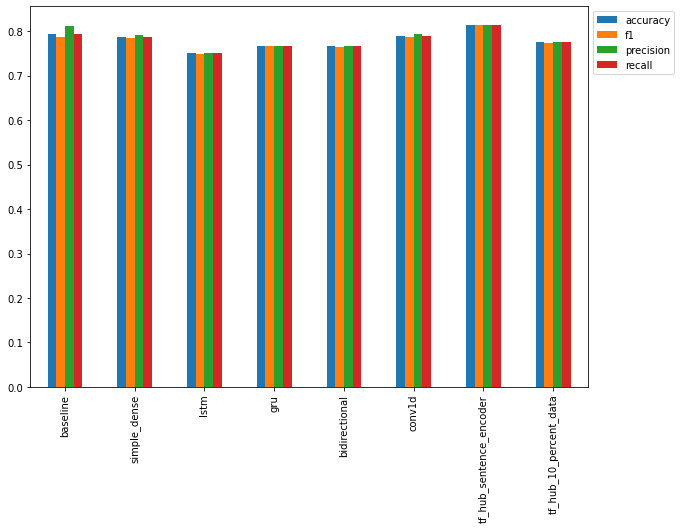

In [56]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

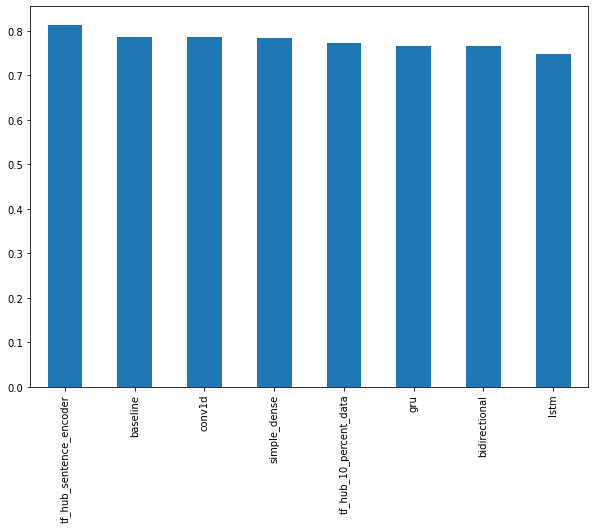

In [57]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Uploading Model training logs to Tensorboard.dev

In [58]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./model_log \
  --name "NLP modelling experiments" \
  --description "A series of different NLP modellings experiments with various models" \
  --one_shot # exits the uploader when upload has finished


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./model_log

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) no


In [59]:
# to see the previos experiments we ran on tensorboard
!tensorboard dev list


***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 303, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.7/dist-packages/absl/app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/program.py", line 276, in main
    return runner(self.flags) or 0
  File "/usr/local/lib/python3.7/dist-package

In [60]:
# to remove previous experiments, you can do so using the following command
!tensorboard dev delete --experiment_id DcDqaNDoRlKPbSLyKRZWTg


***** TensorBoard Uploader *****

This will delete the experiment on https://tensorboard.dev with the
following experiment ID:

DcDqaNDoRlKPbSLyKRZWTg

You have chosen to delete an experiment. All experiments uploaded
to TensorBoard.dev are publicly visible. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.7/dist-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.7/dist-packages/absl/a

# Saving and Loading a Trained Model
Although training time didn't take very long, it's good practice to save your trained models to avoid having to retrain them.

Saving your models also enables you to export them for use elsewhere outside of your notebooks, such as in a web application.

There are two main ways of saving a model in TensorFlow:

- The HDF5 format.
- The SavedModel format (default).

In [61]:
# Save tfhub sentence encoder model to HDF5 format
model_6.save("model_6.h5")

If you save a model as a HDF5, when loading it back in, you need to let TensorFlow know about any custom objects you've used (e.g. components which aren't built from pure TensorFlow, such as TensorFlow Hub components).

In [62]:
# Load model with custom HUB LAYER (required with HDF5 format)
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects = {"KerasLayer":hub.KerasLayer})

In [63]:
# How does our loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4231 - accuracy: 0.8150


[0.42305684089660645, 0.8149606585502625]

Calling the save() method on our target model and passing it a filepath allows us to save our model in the SavedModel format.

In [64]:
# Save TF Hub Sentence Encoder model to SavedModel Format (default)
model_6.save("model_6_SavedModel_format")

INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


INFO:tensorflow:Assets written to: model_6_SavedModel_format/assets


If you use SavedModel format (default), you can reload your model without specifying custom objects using the tensorflow.keras.models.load_model() function.

In [65]:
# Load TF Hub Sentence Encoder SavedModel
loaded_model_6_SavedModel = tf.keras.models.load_model("model_6_SavedModel_format")

In [66]:
# Evaluate loaded SavedModel
loaded_model_6_SavedModel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4231 - accuracy: 0.8150


[0.42305684089660645, 0.8149606585502625]

As you can see saving and loading our model with either format results in the same performance.

🤔 Question: Should you used the SavedModel format or HDF5 format?

For most use cases, the SavedModel format will suffice. However, this is a TensorFlow specific standard. If you need a more general-purpose data standard, HDF5 might be better.

*   List item
*   List item



# Finding the Most Wrong Examples
To make things visual, let's take our best performing model's prediction probabilities and classes along with the validation samples (text and ground truth labels) and combine them in a pandas DataFrame.

- If our best model still isn't perfect, what examples is it getting wrong?
- Which ones are the most wrong?
- Are there some labels which are wrong? E.g. the model gets it right but the ground truth label doesn't reflect this


In [67]:
# download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip

--2022-01-18 08:20:57--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  58.5MB/s    in 20s     

2022-01-18 08:21:17 (46.2 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]



In [68]:
# unzip the model
!unzip 08_model_6_USE_feature_extractor.zip

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variables.index  
  inflating: 08_model_6_USE_feature_extractor/saved_model.pb  


In [69]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [70]:
# make predictions with this loaded model
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10] # these should be in label format

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [71]:
# Create DataFrame with Validation Sentences, validation_labels and best performing model predictions + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": tf.squeeze(model_6_pretrained_pred_probs)})

In [72]:
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [73]:
# Find the wrong predictions and sorting by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)

In [74]:
most_wrong[:10] # these are false positives

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [75]:
most_wrong.tail() # these are false negatives

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


Finally, we can write some code to visualize the sample text, truth label, prediction class and prediction probability. Because we've sorted our samples by prediction probability, viewing samples from the head of our most_wrong DataFrame will show us false positives.

A reminder:
-    0 = Not a real diaster Tweet
-   1 = Real diaster Tweet



In [76]:
# Check the False Positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354543447494507
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

In [77]:
# check the false negatives (model predicts 0 when it should be 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1.0, Prob: 0.9101957678794861
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target: 0, Pred: 1.0, Prob: 0.8769821524620056
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target: 0, Pred: 1.0, Prob: 0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target: 0, Pred: 1.0, Prob: 0.8354543447494507
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target: 0, Pred: 1.0, Prob: 0.8272132873535156
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target: 0, Pred: 1.0, Prob: 0.814815878868103
Text:
@SonofLiberty357 all illuminated by the brightly burning buildings all around the town!

----

# Making Predictions on the Test Dataset

In [78]:
# Making predictions on the test dataset
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample])) # our model expects a list as input
  pred = tf.round(pred_prob)
  print(f"Pred: {int(pred)}, Prob: {pred_prob}")
  print(f"Text:\n{test_sample}\n")
  print("---------\n")

Pred: 0, Prob: 0.16429859399795532
Text:
Police siren sound effect 1 via Play Tube Fre http://t.co/BLWnTMyQmQ

---------

Pred: 1, Prob: 0.8632283806800842
Text:
Investigators say a fatal Virgin Galactic spaceship crash last year was caused by structural failure after the... http://t.co/SYL7ou7qVW

---------

Pred: 0, Prob: 0.14263473451137543
Text:
Most Popular Content Top story: Barrel Bombs Not ISIS Are the Greatest ThreatÛ_ http://t.co/c8YYUWmefG see more http://t.co/BsMz4qlLBN

---------

Pred: 0, Prob: 0.21227750182151794
Text:
#Sport - Shane Warne and Ricky Ponting shocked by Australia batting collapse at Trent Bridge Australian grea... http://t.co/c41iUMknis

---------

Pred: 1, Prob: 0.940841019153595
Text:
A demolished Palestinian village comes back to life http://t.co/Jsf5OFB3m6 via @wagingnv http://t.co/Hskd5MUosM

---------

Pred: 1, Prob: 0.9476558566093445
Text:
'The longer you wait the more people die': #Lafayette theater shooting first responders relied on training: h

# Predicting on Tweets from the wild

In [80]:
# Turn Tweet into string
anmol_tweet = "Life like an ensemble: take the best choices from others and make your own"

In [81]:
def predict_on_sentence(model, sentence):
  """
  Uses model to make a prediction on sentence.

  Returns the sentence, the predicted label and the prediction probability.
  """
  pred_prob = model.predict([sentence])
  pred_label = tf.squeeze(tf.round(pred_prob)).numpy()
  print(f"Pred: {pred_label}", "(real disaster)" if pred_label > 0 else "(not real disaster)", f"Prob: {pred_prob[0][0]}")
  print(f"Text:\n{sentence}")

In [83]:
# Make a prediction on Tweet from the wild
predict_on_sentence(model=model_6, # use the USE model
                    sentence=anmol_tweet)

Pred: 0.0 (not real disaster) Prob: 0.0619945302605629
Text:
Life like an ensemble: take the best choices from others and make your own


In [85]:
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [87]:
# Predict on diaster Tweet 1
predict_on_sentence(model=model_6,
                    sentence = beirut_tweet_1)

Pred: 1.0 (real disaster) Prob: 0.9686116576194763
Text:
Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon


In [88]:
# Predict on disaster Tweet 2
predict_on_sentence(model = model_6,
                    sentence = beirut_tweet_2)

Pred: 1.0 (real disaster) Prob: 0.9781792759895325
Text:
#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon


# Speed Score Trade-Off

In [89]:
model_6_results

{'accuracy': 81.49606299212599,
 'f1': 0.8143707124948604,
 'precision': 0.8150356086855799,
 'recall': 0.8149606299212598}

In [90]:
baseline_results

{'accuracy': 79.26509186351706,
 'f1': 0.7862189758049549,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706}

One of the final tests we're going to do is to find the speed/score tradeoffs between our best model and baseline model.

Why is this important?

Although it can be tempting to just choose the best performing model you find through experimentation, this model might not actually work in a production setting.

Put it this way, imagine you're Twitter and receive 1 million Tweets per hour (this is a made up number, the actual number is much higher). And you're trying to build a diaster detection system to read Tweets and alert authorities with details about a diaster in close to real-time.

Compute power isn't free so you're limited to a single compute machine for the project. On that machine, one of your models makes 10,000 predictions per second at 80% accuracy where as another one of your models (a larger model) makes 100 predictions per second at 85% accuracy.

Which model do you choose?

Is the second model's performance boost worth missing out on the extra capacity?

Of course, there are many options you could try here, such as sending as many Tweets as possible to the first model and then sending the ones which the model is least certain of to the second model.

The point here is to illustrate the best model you find through experimentation, might not be the model you end up using in production.

To make this more concrete, let's write a function to take

In [92]:
# Lets make a function to measure the time of prediction
import time

def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples) # make predictions
  end_time = time.perf_counter() # get the finish time
  total_time = end_time - start_time # calculate how long the predictions took to make
  time_per_pred = total_time/ len(samples)
  return total_time, time_per_pred

In [93]:
# Calculate TF Hub Sentence Encoder prediction times
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_pred_time, model_6_time_per_pred

(0.24283987799981333, 0.0003186875039367629)

In [99]:
# Calculate Naive Bayes prediction times
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.01820917900022323, 2.389656036774702e-05)


It seems with our current hardware (in my case, I'm using a Google Colab notebook) our best performing model takes over 10x the time to make predictions as our baseline model.

Is that extra prediction time worth it?

Let's compare time per prediction versus our model's F1-scores.

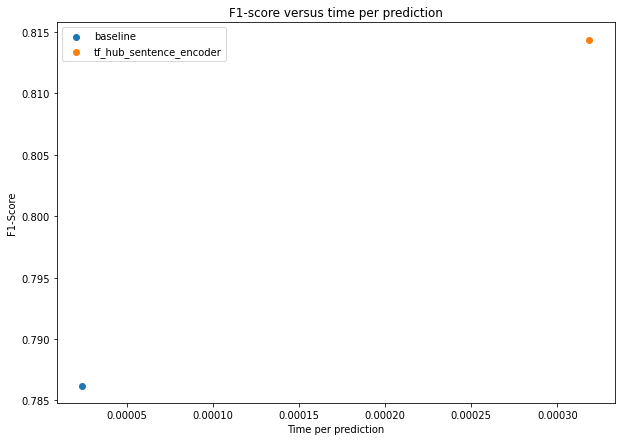

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-Score");

# Download all the Files